# Read and process groundwater data ILVO agricultural park

Load essential Python modules

In [1]:
import pandas as pd
import xlrd
import os
import glob
import matplotlib.pyplot as plt

## Read raw data from excell files and plot for quick inspection

### Read data

In [39]:
path = os.getcwd()
os.chdir('raw_data')
datapath = os.getcwd()

xls_files = glob.glob(os.path.join(datapath, "*.xlsx"))
    
#loop over the list of xls files
ind = 0
diver_names={}
for f in xls_files:
    # read the csv file
    df = pd.read_excel(f)
    # remove double copied parts of the logged data from the raw data files
    df=df.drop_duplicates()  
    # print the location and filename for check
    print('Location:', f)
    print('File Name:', f.split("\\")[-1])
    # merge all data in 1 dataframe
    if ind == 0:
        #First data frame loaded
        GWdata = df
    else:
        # Paste the rest to this dataframe
        GWdata = GWdata.append(df, ignore_index=True)
    
    ind = ind + 1 
#Remove empty columns from the dataframe    
GWdata.drop(labels=['Conductivity', 'WaterLevel','WaterLevelReference','Salinity'], axis=1)

# Read manually measured water dephts for inspection of the data    
os.chdir('info')
df_info = pd.read_excel('manual_check_water_depth.xlsx')
    
os.chdir(path)

Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701135826_AP825.xlsx
File Name: ILVO_210701135826_AP825.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701140247_AP707.xlsx
File Name: ILVO_210701140247_AP707.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701140912_AZ649.xlsx
File Name: ILVO_210701140912_AZ649.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701141446_AG083.xlsx
File Name: ILVO_210701141446_AG083.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701141936_CA186.xlsx
File Name: ILVO_210701141936_CA186.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groundwater\raw_data\ILVO_210701142455_CA969.xlsx
File Name: ILVO_210701142455_CA969.xlsx
Location: C:\Users\sgarre\PycharmProjects\onderzoekskouter_water\groun

In [40]:
GWdata.head(5)


,MonitoringPoint,SerialNumber,TimeStamp,Pressure,Temperature,Conductivity,WaterLevel,WaterLevelReference,Salinity
0,ILVO,AP825,2021-06-11 09:00:00,1040.750,22.500000,NaN,NaN,NaN,NaN
1,ILVO,AP825,2021-06-11 09:05:00,1040.700,22.460000,NaN,NaN,NaN,NaN
2,ILVO,AP825,2021-06-11 09:10:00,1040.700,22.426667,NaN,NaN,NaN,NaN
3,ILVO,AP825,2021-06-11 09:15:00,1041.125,22.403333,NaN,NaN,NaN,NaN
4,ILVO,AP825,2021-06-11 09:20:00,1041.500,22.390000,NaN,NaN,NaN,NaN


In [4]:
df_info.head(5)

,SerialNumber,Time,Depth in cm,Depth in cm (after correction well height),Remarks
0,AP689,NaT,166,53,NaN
1,AP689,NaT,168,55,NaN
2,AP689,2021-06-11 11:27:00,167,54,NaN
3,AP689,2021-06-22 12:40:00,117,4,NaN
4,AP689,2021-07-01 00:00:00,121,8,NaN


### Plot raw data for visual check

In [35]:
def plot_gb_time_series(df, ts_name, gb_name, value_name, figsize=(30,7), title=None):
    '''
    Runs groupby on Pandas dataframe and produces a time series chart.

    Parameters:
    ----------
    df : Pandas dataframe
    ts_name : string
        The name of the df column that has the datetime timestamp x-axis values.
    gb_name : string
        The name of the df column to perform group-by.
    value_name : string
        The name of the df column for the y-axis.
    figsize : tuple of two integers
        Figure size of the resulting plot, e.g. (20, 7)
    title : string
        Optional title
    '''
    #xtick_locator = DayLocator(interval=1)
    #xtick_dateformatter = DateFormatter('%m/%d/%Y')
    fig, ax = plt.subplots(figsize=figsize)
    for key, grp in df.groupby([gb_name]):
        ax = grp.plot(ax=ax, kind='line', x=ts_name, y=value_name, label=key, marker='.')
    #ax.xaxis.set_major_locator(xtick_locator)
    #ax.xaxis.set_major_formatter(xtick_dateformatter)
    ax.autoscale_view()
    ax.legend(loc='upper left')
    _ = plt.xticks(rotation=90, )
    _ = plt.grid()
    _ = plt.xlabel('')
    _ = plt.ylim(df[value_name].min(), df[value_name].max())
    _ = plt.ylabel(value_name)
    if title is not None:
        _ = plt.title(title)
    _ = plt.show()

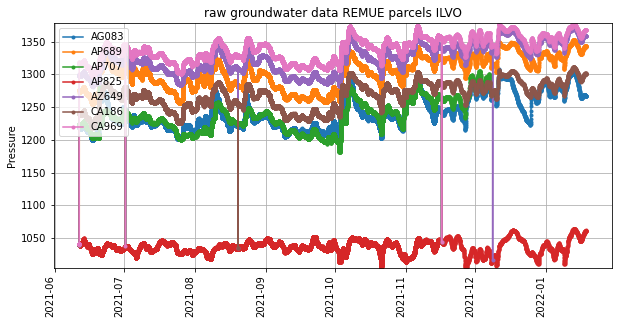

In [36]:
# Do the actual plotting using the abovedefined function

plot_gb_time_series(GWdata, 'TimeStamp', 'SerialNumber', 'Pressure',
                    figsize=(10, 5), title="raw groundwater data REMUE parcels ILVO")

In [49]:
GWdata.SerialNumber.unique()[:]

array(['AP825', 'AP707', 'AZ649', 'AG083', 'CA186', 'CA969', 'AP689'],
      dtype=object)

## Processing steps

Dataset Processing explanation						
1. Collect TP from divers						
2. TP - AP = WP						
3. Take the timestep "t" at which a manual measurement is realized						
4. H(t) = TW-WD(t)						
4. H (t+1) = H(t)  + (WP (t+1) - WP (t))/100						
						
						
						
With :						
TP = Total Pressure (cmH20)						
AP= Air Pressure (cmH20)						
WP= Water Pressure (cmH20)						
H=Hydraulic Head (mTAW)						
TW=Top well Elevation (mTAW)						
WD=Water depth from the top well (m)						
						
						
| well   name | well   name | soil elevation(mTAW) | well height above the ground (m) | Top well (mTAW) |
|:-----------:|:-----------:|:--------------------:|:--------------------------------:|:---------------:|
|  AP707  |   Remue_6   |         18,15        |                 1                |      19,15      |
|   CA969   |   Remue_5   |         14,69        |               1,06               |      15,75      |
|   CA186  |   Remue_4   |         13,5         |               1,15               |      14,65      |
|   AZ649   |   Remue_3   |         14,75        |                 1                |      15,75      |
|   AG083  |   Remue_2   |         13,53        |                1,2               |      14,73      |
|   AP689   |   Remue_1   |         14,34        |               1,13               |      15,47      |

In [ ]:
# To DO
Dict = { SerialNumber : GWdata.SerialNumber.unique(), 
        WellName : ['Remue_','','','','',''],
        'A' : {},
        'B' : {}}
print("Dict well info: ")
print(Dict)